# Figure 3

In [1]:
from netCDF4 import Dataset
import ols, numpy as np
# import data
from scipy import stats
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import xarray as xr

This code requires a netcdf file (ceres_era.nc) containing CERES data and reanalysis temperatures.  

The following commands created the file:
~~~~
cdo -f nc fldmean -select,name=t,level=500 /sn1/dessler/era/era_t_q_2000-2017.nc gatm.nc   
cdo -f nc fldmean -chname,t,t_trop -sellonlatbox,0,360,-30,30 -select,name=t,level=500 /sn1/dessler/era/era_t_q_2000-2017.nc tatm.nc   
cdo -f nc fldmean -select,name=t2m /sn1/dessler/era/era_t2m_albedo_2000-2017.nc gt2m.nc   
cdo -f nc fldmean -chname,t2m,ts_trop -sellonlatbox,0,360,-30,30 -select,name=t2m /sn1/dessler/era/era_t2m_albedo_2000-2017.nc tt2m.nc   
cdo -f nc merge  /sn1/dessler/ceres/CERES_EBAF-TOA_Ed4.0_Subset_200003-201701.nc gatm.nc tatm.nc gt2m.nc tt2m.nc ceres_era.nc   
rm -f gatm.nc tatm.nc gt2m.nc tt2m.nc
~~~~
*era_t_q_2000-2017.nc*: contains 3D temperature field, downloaded from ECMWF;
*era_t2m_albedo_2000-2017.nc*: contains 2D 2-meter temperature field, downloaded from ECMWF;
*CERES_EBAF-TOA_Ed4.0_Subset_200003-201701.nc*: contains global average CERES TOA net flux, downloaded from ceres.larc.nasa.gov

Read in data

In [2]:
def detrend(ovar):
    """linear detrend of data set; then take anomaly"""
    ovar1=ovar.squeeze()
    fitx=ols.ols(ovar1,np.arange(len(ovar1)))
    ovar1 = ovar1 - np.arange(len(ovar1))*fitx.b[1]
    ovar1=ovar1.groupby('time.month')-ovar1.groupby('time.month').mean(dim='time') # take anomaly

    return np.array(ovar1.squeeze()) # return numpy array

ceres=xr.open_dataset('ceres_era.nc')
ceres=ceres.groupby('time.month')-ceres.groupby('time.month').mean(dim='time') # take anomaly

flux = detrend(ceres.gtoa_net_all_mon)
ts = detrend(ceres.t2m)
ta = detrend(ceres.t_trop)

Plot up results

In [3]:
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

## Figure 3

(-0.6, 0.6)

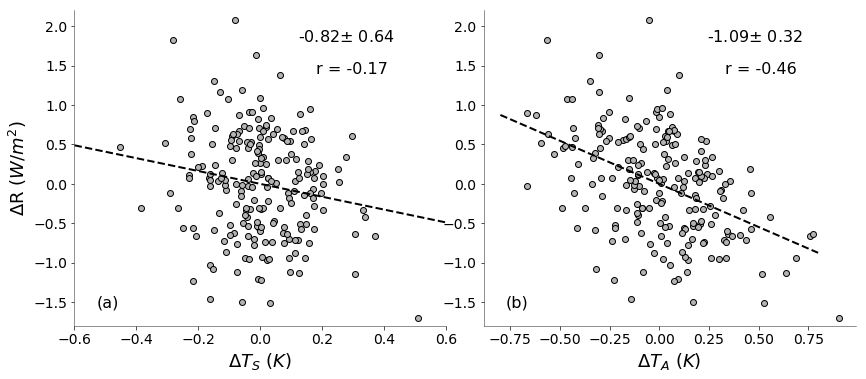

In [4]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(14,6))
plt.subplots_adjust(wspace=0.1,bottom=0.15)

for tdata,ax,labx in zip([ts,ta],axes.flatten(),'a,b'.split(',')):
		
	fitx=ols.ols(flux,tdata);fitx.est_auto()
	ax.plot(tdata,flux,'o',c='0.7',markeredgecolor='k');colorplot(ax)
	
	# ax.set_title(labx[2:],fontsize=14)
	ax.text(0.06,0.06,'({})'.format(labx),fontsize=16,transform=ax.transAxes)

# 	ax.grid()
	xran=np.linspace(-0.8,0.8)
	ax.plot(xran,xran*fitx.b[1]+fitx.b[0],'k',lw=2,ls='dashed')
	ax.text(0.6,0.9,'%5.2f$\pm$%5.2f' % (fitx.b[1],fitx.conf90[1]),fontsize=16,transform=ax.transAxes)
	ax.text(0.65,0.8,'r = %5.2f' % (-np.sqrt(fitx.R2)),fontsize=16,transform=ax.transAxes)

axes[0].set_ylabel('$\Delta$R ($W/m^2$)',fontsize=18)
axes[0].set_xlabel('$\Delta T_S$ ($K$)',fontsize=18)
axes[1].set_xlabel('$\Delta T_A$ ($K$)',fontsize=18)
axes[0].set_ylim(-1.8,2.2)
axes[0].set_xlim(-0.6,0.6);
# savefig('fig3.eps')

## other code

### lag plots

In [5]:
import smooth

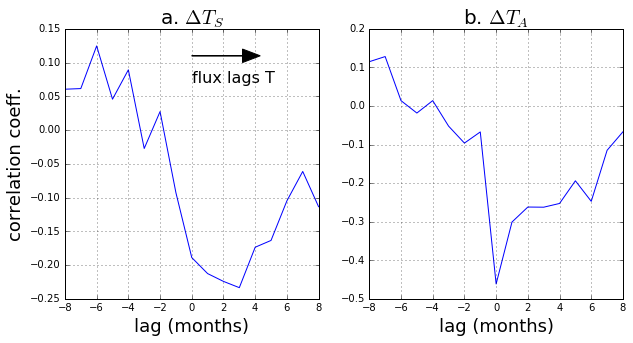

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
plt.subplots_adjust(wspace=0.2,bottom=0.15)

f1=flux
for tdata,ax,labx in zip([ts,ta],axes.flatten(),\
	['a. $\Delta T_S$','b. $\Delta T_A$']):
	
	lag=[]
	r1=range(-8,9)
	for ii in r1:
		if ii > 0: # temperature leads flux
			lag.append(stats.linregress(tdata[:-ii],f1[ii:]).rvalue)
		if ii < 0: # flux leads temperature
			lag.append(stats.linregress(tdata[-ii:],f1[:ii]).rvalue)
		if ii == 0: 
			lag.append(stats.linregress(tdata,f1).rvalue)

	ax.plot(r1,lag)
	ax.grid()
	ax.set_xlabel('lag (months)',fontsize=18)
	ax.set_title(labx,fontsize=20)
axes[0].set_ylabel('correlation coeff.',fontsize=18)

# axes[0].arrow(2, 0.1, 4, 0, head_width=0.02, head_length=1, fc='k', ec='k')
axes[0].arrow(0.5,0.9, 0.2, 0, head_width=0.05, head_length=0.07, fc='k', ec='k',transform=axes[0].transAxes)
axes[0].text(0.5,0.8,'flux lags T',fontsize=16,transform=axes[0].transAxes)

_positive values means temperature leads flux, negative values mean flux leads temperature_

This looks a lot like the figures in the supplement to Xie et al. 2016

### annual vs. monthly correlations

Calculate slope of annual average R vs. annual average T (all detrended).  Do this 12 times — starting in different months.  Then estimate the average and $\sigma$ for the 12-month estimates.

In [21]:
slope=[]
for ii in range(12):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,6))
    plt.subplots_adjust(wspace=0.1,bottom=0.15)
    
    ind=np.arange((len(flux1)/12-1)*12)+ii

    f1=flux[ind].reshape(len(ind)/12,12).mean(axis=1)
    ts1=ts[ind].reshape(len(ind)/12,12).mean(axis=1)
    ta1=ta[ind].reshape(len(ind)/12,12).mean(axis=1)
    
    for tdata,ax,labx in zip([ts1,ta1],axes.flatten(),'a,b'.split(',')):

        fitx=ols.ols(f1,tdata);fitx.est_auto()
        slope.append(fitx.b[1])
        ax.plot(tdata,f1,'o',c='0.7');colorplot(ax)

        # ax.set_title(labx[2:],fontsize=14)
        ax.text(0.06,0.06,'({})'.format(labx),fontsize=16,transform=ax.transAxes)

    # 	ax.grid()
        xran=np.linspace(-0.8,0.8)
        ax.plot(xran,xran*fitx.b[1]+fitx.b[0],'k',lw=2,ls='dashed')
        ax.text(0.6,0.9,'%5.2f$\pm$%5.2f' % (fitx.b[1],fitx.conf90[1]),fontsize=16,transform=ax.transAxes)
        ax.text(0.65,0.8,'r = %5.2f' % (-np.sqrt(fitx.R2)),fontsize=16,transform=ax.transAxes)

    axes[0].set_ylabel('$\Delta$R',fontsize=20)
    axes[0].set_xlabel('$\Delta T_S$',fontsize=20)
    axes[1].set_xlabel('$\Delta T_A$',fontsize=20)
    axes[0].set_ylim(-1.8,2.2)
    axes[0].set_xlim(-0.9,1)
    plt.close()
    # savefig('fig1.eps')
    
print 'average of lambda: {:.2f} +/- {:.2f}'.format(np.average(slope[::2]),np.std(slope[::2]))
print 'average of theta: {:.2f} +/- {:.2f}'.format(np.average(slope[1::2]),np.std(slope[1::2]))


average of lambda: -1.11 +/- 0.32
average of theta: -0.86 +/- 0.13


### surface T lag plots

In [26]:
def corrmat(a,b):
    """covmat(a,b): a is a vector, b is a matrix"""
    
    s1=np.shape(b)
    b1=np.copy(np.array(b));a1=np.copy(np.array(a))
    b1=b1.reshape(s1[0],s1[2]*s1[1])
    
    a1=a1-np.average(a1);b1=b1-np.average(b1,axis=0)
    
    c1=np.matrix(a)*np.matrix(b1)
    c1=c1.reshape(s1[1],s1[2])/s1[0]

    c1 /= np.std(a)
    c1 /= np.std(b,axis=0)
    
    return np.array(c1)


In [52]:
d1=ceres=xr.open_dataset('/sn1/dessler/era/era_t2m_albedo_2000-2017.nc')
d1

<xarray.Dataset>
Dimensions:    (latitude: 91, longitude: 180, time: 203)
Coordinates:
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 ...
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 80.0 78.0 76.0 ...
  * time       (time) datetime64[ns] 2000-03-01 2000-04-01 2000-05-01 ...
Data variables:
    sp         (time, latitude, longitude) float64 1.024e+05 1.024e+05 ...
    t2m        (time, latitude, longitude) float64 249.5 249.5 249.5 249.5 ...
    skt        (time, latitude, longitude) float64 249.6 249.6 249.6 249.6 ...
    fal        (time, latitude, longitude) float64 0.7656 0.7656 0.7656 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-04-15 18:23:11 GMT by grib_to_netcdf-2.1.0: grib_to_ne...

In [53]:
leadlag=[]
for ii in range(8,0,-1): # global average lags
    leadlag.append(corrmat(ts[ii:],d1.t2m[:-ii,]))

leadlag.append(corrmat(ts,d1.t2m)) # zero lag

for ii in range(1,9): # global average leads
    leadlag.append(corrmat(ts[:-ii],d1.t2m[ii:,]))

In [ ]:
laglab=range(-8,9)
for ii,lagx in zip(leadlag,laglab):
    figure()
    pcolormesh(d1.longitude,d1.latitude,ii,vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
    title('lag = {} months'.format(lagx),fontsize=20)

In [46]:
d1=ceres=xr.open_dataset('/sn1/dessler/era/era_t_q_2000-2017.nc')
d2=d1.sel(level=500)
d2

<xarray.Dataset>
Dimensions:    (latitude: 91, longitude: 180, time: 203)
Coordinates:
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 ...
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 80.0 78.0 76.0 ...
    level      int32 500
  * time       (time) datetime64[ns] 2000-03-01 2000-04-01 2000-05-01 ...
Data variables:
    t          (time, latitude, longitude) float64 233.6 233.6 233.6 233.6 ...
    q          (time, latitude, longitude) float64 0.0001289 0.0001289 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-04-15 17:44:15 GMT by grib_to_netcdf-2.1.0: grib_to_ne...

In [47]:
leadlag=[]
for ii in range(8,0,-1): # global average lags
    leadlag.append(corrmat(ta[ii:],d2.t[:-ii,]))

leadlag.append(corrmat(ta,d2.t)) # zero lag

for ii in range(1,9): # global average leads
    leadlag.append(corrmat(ta[:-ii],d2.t[ii:,]))

In [ ]:
laglab=range(-8,9)
for ii,lagx in zip(leadlag,laglab):
    figure()
    pcolormesh(d1.longitude,d1.latitude,ii,vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
    title('lag = {} months'.format(lagx),fontsize=20)

### figure for talk

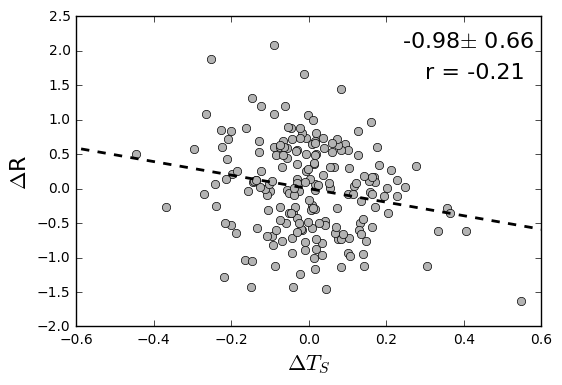

In [17]:
tdata=ovar[3]
fitx=ols.ols(flux,tdata);fitx.est_auto()
plot(tdata,flux,'o',c='0.7');colorplot(ax)

xran=np.linspace(-0.8,0.8)
plot(xran,xran*fitx.b[1]+fitx.b[0],'k',lw=2,ls='dashed')

ylabel('$\Delta$R',fontsize=16)
xlabel('$\Delta T_S$',fontsize=16)
# ylim(-1.8,2.2)
xlim(-0.6,0.6)

ax=gca()
text(0.7,0.9,'%5.2f$\pm$%5.2f' % (fitx.b[1],fitx.conf90[1]),fontsize=16,transform=ax.transAxes)
text(0.75,0.8,'r = %5.2f' % (-np.sqrt(fitx.R2)),fontsize=16,transform=ax.transAxes)

# savefig('figTalk.eps')